In [74]:
from skimage.segmentation import clear_border
from local_utils import interval_mapping
import matplotlib.pyplot as plt
# import pytesseract
import numpy as np
import imutils
import cv2
import easyocr
import matplotlib.gridspec as gridspec
from skimage import color

In [54]:
def align_images(image, template, maxFeatures=500, keepPercent=0.2,
	debug=False):
	# convert both the input image and template to grayscale
	
	templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
	imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # use ORB to detect keypoints and extract (binary) local
	# invariant features
	orb = cv2.ORB_create(maxFeatures)
	(kpsA, descsA) = orb.detectAndCompute(imageGray, None)
	(kpsB, descsB) = orb.detectAndCompute(templateGray, None)
	# match the features
	method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
	matcher = cv2.DescriptorMatcher_create(method)
	matches = matcher.match(descsA, descsB, None)
    # sort the matches by their distance (the smaller the distance,
	# the "more similar" the features are)
	matches = sorted(matches, key=lambda x:x.distance)
	# keep only the top matches
	keep = int(len(matches) * keepPercent)
	matches = matches[:keep]
	# check to see if we should visualize the matched keypoints
	if debug:
		matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
			matches, None)
		matchedVis = imutils.resize(matchedVis, width=1000)
		plt.imshow(matchedVis)
		# cv2.waitKey(0)
    # allocate memory for the keypoints (x, y)-coordinates from the
	# top matches -- we'll use these coordinates to compute our
	# homography matrix
	ptsA = np.zeros((len(matches), 2), dtype="float")
	ptsB = np.zeros((len(matches), 2), dtype="float")
	# loop over the top matches
	for (i, m) in enumerate(matches):
		# indicate that the two keypoints in the respective images
		# map to each other
		ptsA[i] = kpsA[m.queryIdx].pt
		ptsB[i] = kpsB[m.trainIdx].pt
    # compute the homography matrix between the two sets of matched
	# points
	(H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
	# use the homography matrix to align the images
	(h, w) = template.shape[:2]
	aligned = cv2.warpPerspective(image, H, (w, h))
	# return the aligned image
	return aligned
    

(0.0, 1.0, 0.0, 1.0)

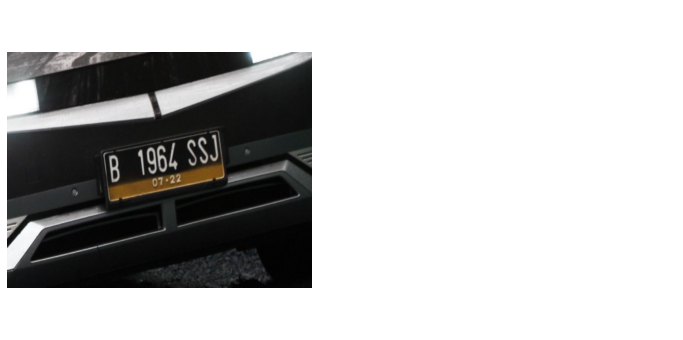

In [77]:
img = cv2.imread('./dataset/plat2.jpg')

img = cv2.resize(img, (620,480) )
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grey scale
gray = cv2.bilateralFilter(gray, 13, 15, 15)
edged = cv2.Canny(gray, 150, 200) #Perform Edge detection

contours = cv2.findContours(edged.copy(),cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours,key=cv2.contourArea, reverse = True)[:10]
screenCnt = np.zeros((4, 1, 2))


for c in contours:
    
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)

    if len(approx) == 4:
        screenCnt = approx
        break

# if screenCnt.all() == 0:
#     detected = 0
#     print ("No contour detected")
# else:
#     cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3)

# mask = np.zeros(gray.shape,np.uint8)
# new_image = cv2.drawContours(mask, [screenCnt], 0, 255, -1)
# new_image = cv2.bitwise_and(img,img,mask=mask)

# (x, y) = np.where(mask == 255)
# (topx, topy) = (np.min(x), np.min(y))
# (bottomx, bottomy) = (np.max(x), np.max(y))
# Cropped = img[topx:bottomx+1, topy:bottomy+1]

# cropped_text = interval_mapping(Cropped, 0.0, 1.0, 0, 255)
# reader = easyocr.Reader(['en'])
# result = reader.readtext(np.uint8(cropped_text))
# print(result)

# # text = pytesseract.image_to_string(Cropped, config='--psm 11')
# # print("programming_fever's License Plate Recognition\n")
# # print("Detected license plate Number is:",text)
# print(img.shape)
# plt.imshow(mask)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(edged)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
# plt.imshow(Cropped)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [56]:
Cropped.shape

(347, 184, 3)

In [57]:
temp = cv2.imread('./dataset/template.jpg')
Cropped = imutils.resize(Cropped, width=139)
temp = imutils.resize(temp, width=139)

tempGray = color.rgb2gray(temp)
imgGray = color.rgb2gray(Cropped)

In [58]:
aligned = align_images(Cropped, temp, debug=True)

error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\core\src\batch_distance.cpp:275: error: (-215:Assertion failed) type == src2.type() && src1.cols == src2.cols && (type == CV_32F || type == CV_8U) in function 'cv::batchDistance'
